# Vivarium Trace Analysis Example

This notebook demonstrates how to analyze simulation traces from Vivarium.

**Prerequisites:**
- Complete at least one experiment run (e.g., `vvm olmo-conformity --suite-config ...`)
- Install analysis dependencies: `pip install -e .[analysis]`


In [1]:
# Standard imports
import json
import sqlite3
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optional: safetensors for activation analysis
try:
    from safetensors.torch import load_file as load_safetensors
    SAFETENSORS_AVAILABLE = True
except ImportError:
    SAFETENSORS_AVAILABLE = False
    print("safetensors not installed - activation analysis unavailable")


## 1. Load Simulation Database

Set the path to your run directory and load the database.


In [2]:
# Configure your run directory path
# Example: runs/20251227_123456_abc123/
RUN_DIR = Path("runs")  # Update this to your run directory

# Find the most recent run if not specified
if RUN_DIR.name == "runs" and RUN_DIR.exists():
    subdirs = sorted([d for d in RUN_DIR.iterdir() if d.is_dir()], reverse=True)
    if subdirs:
        RUN_DIR = subdirs[0]
        print(f"Using most recent run: {RUN_DIR}")

DB_PATH = RUN_DIR / "simulation.db"
ACTIVATIONS_DIR = RUN_DIR / "activations"

print(f"Database path: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")


Using most recent run: runs/20251227_200219_603cc075-b60a-476d-9b21-04c005d92185
Database path: runs/20251227_200219_603cc075-b60a-476d-9b21-04c005d92185/simulation.db
Database exists: True


In [3]:
# Connect to database
conn = sqlite3.connect(str(DB_PATH))
conn.row_factory = sqlite3.Row

# List available tables
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name",
    conn
)
print("Available tables:")
print(tables)


Available tables:
                               name
0               activation_metadata
1             conformity_conditions
2               conformity_datasets
3   conformity_intervention_results
4          conformity_interventions
5                  conformity_items
6             conformity_logit_lens
7                conformity_outputs
8      conformity_probe_projections
9                 conformity_probes
10               conformity_prompts
11          conformity_think_tokens
12           conformity_trial_steps
13                conformity_trials
14                       merkle_log
15                         messages
16                             runs
17                            trace


## 2. Explore Run Metadata and Trial Data


In [4]:
# Get run metadata
runs_df = pd.read_sql_query("SELECT * FROM runs", conn)
print(f"Number of runs: {len(runs_df)}")

if len(runs_df) > 0:
    run = runs_df.iloc[0]
    print(f"\nLatest run:")
    print(f"  Run ID: {run['run_id']}")
    print(f"  Seed: {run['seed']}")
    print(f"  Created: {pd.to_datetime(run['created_at'], unit='s')}")
    
    RUN_ID = run['run_id']
    
# Check if conformity tables exist and query trials
if 'conformity_trials' in tables['name'].values:
    trials_df = pd.read_sql_query(f"""
        SELECT 
            t.trial_id,
            c.name as condition_name,
            i.question,
            i.ground_truth_text,
            o.raw_text as response,
            o.is_correct
        FROM conformity_trials t
        LEFT JOIN conformity_conditions c ON c.condition_id = t.condition_id
        LEFT JOIN conformity_items i ON i.item_id = t.item_id
        LEFT JOIN conformity_outputs o ON o.trial_id = t.trial_id
        WHERE t.run_id = ?
        LIMIT 100
    """, conn, params=(RUN_ID,))
    
    print(f"\nTotal trials loaded: {len(trials_df)}")
    if len(trials_df) > 0:
        print(f"\nConditions: {trials_df['condition_name'].value_counts().to_dict()}")


Number of runs: 1

Latest run:
  Run ID: 603cc075-b60a-476d-9b21-04c005d92185
  Seed: 42
  Created: 2025-12-28 04:02:19.581973076

Total trials loaded: 100

Conditions: {'truth_probe_capture': 40, 'control': 20, 'asch_history_5': 20, 'authoritative_bias': 20}


## 3. Load and Visualize Activation Tensors


Found 210 activation file(s)
Tensor keys: ['trial_d87b2a19.blocks.10.hook_resid_post', 'trial_d87b2a19.blocks.11.hook_resid_post', 'trial_d87b2a19.blocks.12.hook_resid_post', 'trial_d87b2a19.blocks.13.hook_resid_post', 'trial_d87b2a19.blocks.14.hook_resid_post']...


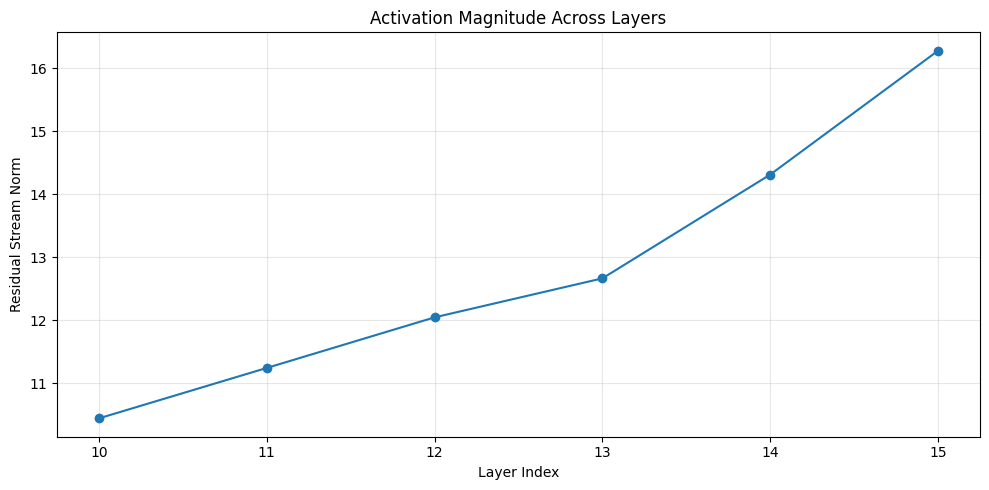

In [5]:
if SAFETENSORS_AVAILABLE and ACTIVATIONS_DIR.exists():
    # List activation files
    activation_files = sorted(ACTIVATIONS_DIR.glob("*.safetensors"))
    print(f"Found {len(activation_files)} activation file(s)")
    
    if activation_files:
        # Load first file
        tensors = load_safetensors(str(activation_files[0]))
        print(f"Tensor keys: {list(tensors.keys())[:5]}...")
        
        # Plot residual stream norms across layers
        resid_keys = sorted([k for k in tensors.keys() if 'hook_resid_post' in k])
        if resid_keys:
            layers, norms = [], []
            for key in resid_keys:
                parts = key.split('.')
                for i, p in enumerate(parts):
                    if p == 'blocks' and i + 1 < len(parts):
                        try:
                            layers.append(int(parts[i + 1]))
                            norms.append(tensors[key].float().norm().item())
                            break
                        except ValueError:
                            continue
            
            if layers:
                fig, ax = plt.subplots(figsize=(10, 5))
                ax.plot(sorted(layers), [n for _, n in sorted(zip(layers, norms))], 'o-')
                ax.set_xlabel('Layer Index')
                ax.set_ylabel('Residual Stream Norm')
                ax.set_title('Activation Magnitude Across Layers')
                ax.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
else:
    print("No activations to analyze (install safetensors or re-run with --capture-activations)")


## 4. Cleanup


In [6]:
# Close database connection
conn.close()
print("Database connection closed")


Database connection closed
